In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset, DataLoader
from random import sample 
import os
import networkx as nx
import scipy.io
from scipy.interpolate import griddata


sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk')
print(sys.path)
from pyCaMOtk.create_mesh_hsphere import mesh_hsphere
from pyCaMOtk.create_mesh_hcube_rnd import mesh_hcube 
from pyCaMOtk.setup_linelptc_sclr_base_handcode import setup_linelptc_sclr_base_handcode
from pyCaMOtk.create_dbc_strct import create_dbc_strct
from pyCaMOtk.create_femsp_cg import create_femsp_cg
from pyCaMOtk.solve_fem import solve_fem
from pyCaMOtk.visualize_fem import visualize_fem
from pyCaMOtk.lfcnsp import LocalFunctionSpace

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source')
from FEM_ForwardModel import analyticalPossion, analyticalConeInterpolation, analyticalHeat2
from GCNNModel import e2vcg2connectivity,PossionNet
from TensorFEMCore_cg import Double,solve_fem_GCNN,create_fem_resjac
import setup_prob_eqn_handcode

torch.manual_seed(0)


c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\python38.zip', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\DLLs', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l', '', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


- 邻接矩阵是取决于单元数量的，和多项式阶数关系不大，单元数量太大邻接矩阵会非常稠密，训练非常慢
- 这样的邻接矩阵建立的方式是否正确？


方形区域上的热方程（非齐次边界条件）
在方形区域 ($[0, 1] \times [0, 1]$) 上求解二维热方程： $u_t = \alpha \nabla^2 u $ 其中 ($\alpha$) 是热扩散系数。

真解
$$u(x, y, t) = e^{-2\pi^2 \alpha t} \sin(\pi x) \sin(\pi y) + x + y $$

边界条件
左边界：$u = y $
右边界：$ u = 1 + y $
上边界：$u = x + 1 $
下边界：$ u = x$
初始条件
$$ u(x, y, 0) = \sin(\pi x) \sin(\pi y) + x + y $$

In [2]:
"""
Hyper prameters
"""
tol=1.0e-16
maxit=1000
delta_t=0.01
analytical = scipy.io.loadmat('C:/Users/puppyCookie/Documents/WeChat Files/wxid_niu084wcxsk322/FileStorage/File/2025-04/Burgers+Equation/Burgers Equation/data/burgers_shock.mat')
t_exact = analytical['t'].flatten()[:,None]
x_exact = analytical['x'].flatten()[:,None]
Exact = np.real(analytical['usol']).T


In [3]:
# GCNN model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model=PossionNet().to(device)
model=model.double()
# 加载模型
#statr_dict=torch.load('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_1.pth')
#model.load_state_dict(statr_dict)

cuda


In [16]:
"""
Set up GCNN-FEM Possion problem
"""
# 算Δu
# 
nin=1 # Number of input variable
nvar=1 # Number of primanry variable
etype='hcube' # Mesh type
c=[0,0] # Domain center
r=1 # Radius
porder=1 # Polywwwnomial order for solution and geometry basis
nel=[10,10] # Number of element in x and y axis

lims = np.array([[0,0.5],[-1, 1]]) # Domain limits
msh=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object


xcg=msh.xcg # Extract node coordinates
print('xcgshape:',xcg.shape)

#xcg[0]是x坐标，xcg[1]是y坐标
ndof=xcg.shape[1] #总节点数，也就是总自由度数
e2vcg=msh.e2vcg # Extract element connectivity 
connectivity=e2vcg2connectivity(msh.e2vcg,'intra') # Extract element connectivity
#输出一下e2vcg


ndim= 2
[[[nan  0.  1.  2.  3.  4.  5.  6.  7.  8. nan 10. 11. 12. 13. 14. 15.
   16. 17. 18. nan 20. 21. 22. 23. 24. 25. 26. 27. 28. nan 30. 31. 32.
   33. 34. 35. 36. 37. 38. nan 40. 41. 42. 43. 44. 45. 46. 47. 48. nan
   50. 51. 52. 53. 54. 55. 56. 57. 58. nan 60. 61. 62. 63. 64. 65. 66.
   67. 68. nan 70. 71. 72. 73. 74. 75. 76. 77. 78. nan 80. 81. 82. 83.
   84. 85. 86. 87. 88. nan 90. 91. 92. 93. 94. 95. 96. 97. 98.]
  [nan  2.  2.  2.  2.  2.  2.  2.  2.  2. nan  2.  2.  2.  2.  2.  2.
    2.  2.  2. nan  2.  2.  2.  2.  2.  2.  2.  2.  2. nan  2.  2.  2.
    2.  2.  2.  2.  2.  2. nan  2.  2.  2.  2.  2.  2.  2.  2.  2. nan
    2.  2.  2.  2.  2.  2.  2.  2.  2. nan  2.  2.  2.  2.  2.  2.  2.
    2.  2. nan  2.  2.  2.  2.  2.  2.  2.  2.  2. nan  2.  2.  2.  2.
    2.  2.  2.  2.  2. nan  2.  2.  2.  2.  2.  2.  2.  2.  2.]]

 [[nan nan nan nan nan nan nan nan nan nan  0.  1.  2.  3.  4.  5.  6.
    7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
   24. 25.

In [17]:
bnd2nbc=np.asarray([0]) # Define the boundary tag!
K=lambda x,el: np.asarray([[1],[0],[0],[1]])
"""
# The flux constant Flux=[du/dx, du/dy]^T=K dot [dphi/dx,dphi/dy]
where phi is the solution polynomial function
""" 
Qb=lambda x,n,bnd,el,fc: 0 # The primary variable value on the boundary
#dbc_idx=[i for i in range(xcg.shape[1]) if np.sum(xcg[:,i]**2)>1-1e-12 or xcg[1,i]*xcg[0,i]==0] # The boundary node id
# 定义边界节点
lower_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[1, i], -1.0)]  # 下边界 (x = -1)
upper_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[1, i], 1.0)]  # 上边界 (x = 1)
left_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[0, i], 0.0)]   # 左边界 (t = 0)

# 合并所有边界节点索引
dbc_idx = lower_boundary_nodes + upper_boundary_nodes + left_boundary_nodes
dbc_idx = np.asarray(dbc_idx)

# 初始化边界值数组
dbc_val = np.zeros_like(dbc_idx, dtype=np.float64)

# 设置边界条件
for idx in range(len(dbc_idx)):
    node = dbc_idx[idx]
    x, y = xcg[0, node], xcg[1, node]
    if node in lower_boundary_nodes or node in upper_boundary_nodes:
        dbc_val[idx] = 0  # 上下边界值为 0
    elif node in left_boundary_nodes:
        dbc_val[idx] = -np.sin(np.pi * y)  # 左边界值为 -sin(pi * x)

print('dbc_val:',dbc_val)
# 创建边界条件结构
dbc = create_dbc_strct(xcg.shape[1] * nvar, dbc_idx, dbc_val)

# 其他参数设置
Src_new = torch.tensor([0.25], dtype=torch.double).to('cuda')
K_new = torch.tensor([[0], [0], [0], [1]]).to('cuda').double().reshape((4,))
parsfuncI = lambda x: torch.cat((K_new, Src_new), axis=0)

dbc_val: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.6915281
  0.99317689  0.92657682  0.62825087  0.08266672 -0.44374385 -0.9122524
 -0.92673687 -0.59770846  0.        ]


In [18]:
'''
# Define pameterized problem, in this case, the governing equation is changing and the loss
# function is changing
'''
S=[5] # Parametrize the source value in the pde -F_ij,j=S_i
LossF=[]
for i in S: 
	f=lambda x,el: i
	prob=setup_prob_eqn_handcode.setup_linelptc_sclr_base_handcode(2,K,f,Qb,bnd2nbc) # Set up the problem
	femsp=create_femsp_cg(prob,msh,porder,e2vcg,porder,e2vcg,dbc)
	fcn=lambda u_:create_fem_resjac('cg',u_,msh.transfdatacontiguous,
									femsp.elem,femsp.elem_data, 
                   				    femsp.ldof2gdof_eqn.ldof2gdof,
                  			        femsp.ldof2gdof_var.ldof2gdof,
									msh.e2e,femsp.spmat,dbc,[i for i in range(ndof) if i not in dbc_idx],parsfuncI,None)
	LossF.append(fcn)

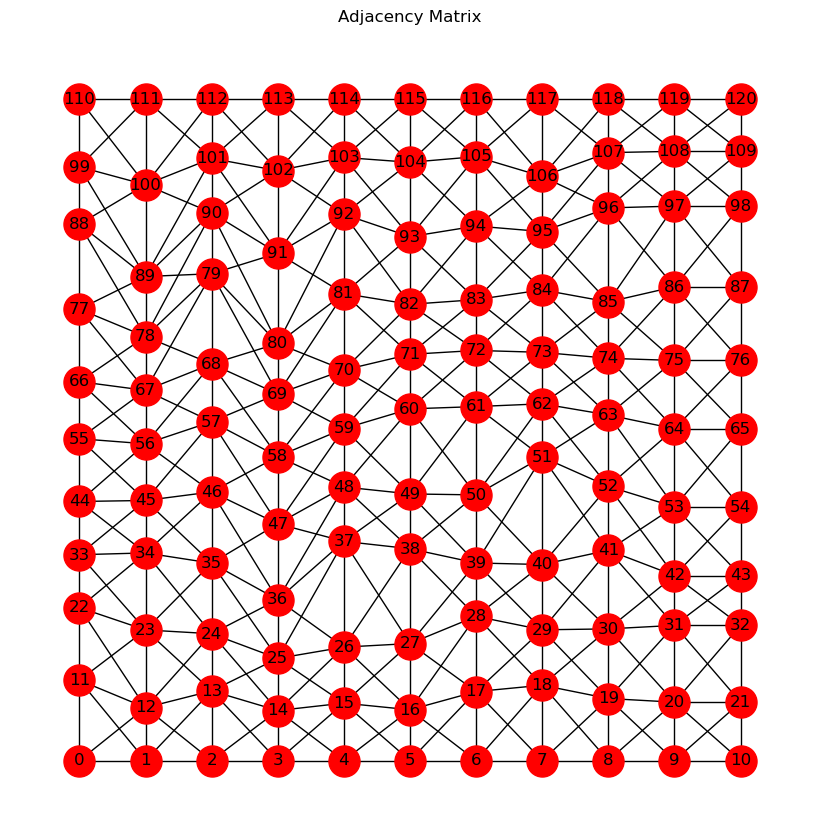

In [19]:
#绘制节点和邻接矩阵的示意图（connectivity是邻接矩阵）
edges = connectivity.cpu().numpy().T.tolist()
G = nx.Graph()
G.add_edges_from(edges)

if xcg.shape[0] == 1:
    # 一维网格：所有节点的y坐标设为0
    pos = {i: (xcg[0, i], 0) for i in range(xcg.shape[1])}
else:
    # 二维网格：直接使用x和y坐标
    pos = {i: (xcg[0, i], xcg[1, i]) for i in range(xcg.shape[1])}
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='r', node_size=500, font_size=12)
plt.title('Adjacency Matrix')
plt.show()

In [21]:
xcg_exact_values = []

# 遍历 xcg 中的每个点
for i in range(xcg.shape[1]):
    # 获取当前点的 t 和 x 值
    t_val, x_val = xcg[0, i], xcg[1, i]
    x_val = float(x_val) 
    differences = np.abs(x - x_val)
    x_idx = np.argmin(differences)
    # 找到 t 和 x 中与当前点最接近的索引
    t_idx = np.argmin(np.abs(t_exact - t_val))  # 找到最接近的 t 的索引
    x_idx = np.argmin(np.abs(x_exact - x_val))  # 找到最接近的 x 的索引

    # 在 Exact 中定位解值
    exact_value = Exact[t_idx, x_idx]
    
    # 将解值存储到结果数组中
    xcg_exact_values.append(exact_value)

# 转换为 NumPy 数组
xcg_exact_values = np.array(xcg_exact_values)


Ufem = xcg_exact_values.reshape([ndof,1])

epoch =  0
Max Rf =============================== tensor(0.0961, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
wallclock time of evl Res=  1.6261053085327148
max Res= 0.09614477008655334
wallclock time of this BP=  0.7809998989105225
>>>>>>>max error<<<<<<< ==================================== 0.48564568761276594
>>>>>>>model source<<<<<<< ======================= Parameter containing:
tensor([0.2500], device='cuda:0', dtype=torch.float64, requires_grad=True)
Solution er =  0.48564568761276594
wallclock time of this epoch=  2.451666831970215
The training reaches the expected loss!
epoch =  1
Max Rf =============================== tensor(0.0590, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
wallclock time of evl Res=  1.6432111263275146
max Res= 0.05900917593867075
wallclock time of this BP=  0.8025062084197998
>>>>>>>max error<<<<<<< ==================================== 0.4759747429440926
>>>>>>>model source<<<<<<< ======================= Parameter contai

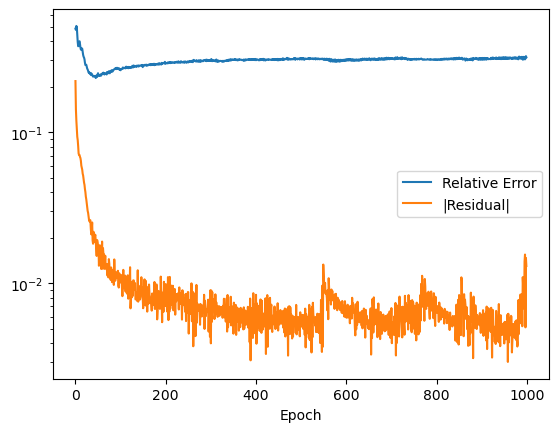

wallclock time of all epochs =  2451.071396589279
K= <function <lambda> at 0x000002BD3F643C10>
Min Error= 0.2282480398080903
Mean Error Last 10 iterations= 0.3095728793555854
Var  Error Last 10 iterations= 3.2392316831704506e-05


: 

In [ ]:
# Define the Training Data
Graph=[]
ii=0
for i in S:
	Ue=Double(Ufem.reshape(ndof,1))
	fcn_id=Double(np.asarray([ii]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	graph=Data(x=Uin,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)
	ii=ii+1
DataList=[[Graph[i]] for i in range(len(S))]
TrainDataloader=DataLoader(DataList,batch_size=1)
# GCNN model
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model=PossionNet().to(device)
#model=model.double()
#存储模型
torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_burgers_rnd.pth')
# Training Data
[model,info]=solve_fem_GCNN(TrainDataloader,LossF,model,tol,maxit)
print('K=',K)
print('Min Error=',info['Er'].min())
print('Mean Error Last 10 iterations=',np.mean(info['Er'][-10:]))
print('Var  Error Last 10 iterations=',np.var(info['Er'][-10:]))

In [ ]:

solution=model(Graph[0].to('cuda'))
#solution = Ufem
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()

#检查真解和数值解的形状是否一致，如果不一致就统一成solution的形状
if Ufem.shape!=solution.shape:
    Ufem=Ufem.reshape(solution.shape)
fig, axes, cbar = visualize_fem(
    msh, 
    udg=solution[e2vcg], 
    ufem=Ufem[e2vcg],        # 传入真解
    opts={"plot_elem": True, "nref": 6}, 
    which_bnd=[]
)

# 分别设置三个子图的标题
titles = ['Numerical Solution', 'Exact Solution', 'Difference']
for ax, title in zip(axes, titles):
    ax.tick_params(axis='both', which='both', 
                   bottom=False, left=False, 
                   top=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    ax.axis('off')

plt.margins(0,0)
plt.tight_layout()              # 自动调整子图间距
plt.show()

In [ ]:
#固定T
print(xcg[0])
T=0.2
#在xcg[0]中找到T最相近的值的索引
idx = np.where((xcg[0] - T)==0)[0]
print('idx:',idx)
#提取对应的x坐标和解值
x_values = xcg[1][idx]
solution_values = solution[idx]
Ufem_values = Ufem[idx]
#绘图
plt.plot(x_values, solution_values, label='Numerical Solution', color='blue')
plt.plot(x_values, Ufem_values, label='Exact Solution', color='red')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution at t = {}'.format(T))
plt.legend()
plt.grid()
plt.show()


In [ ]:
#计算l2误差、l无穷误差、l1误差
l2_error = []
l1_error = []
l_inf_error = []
for i in range(1):
    t = (i+1)*delta_t
    analytical_solution = Ufem
    l2_error.append(np.sqrt(np.sum((solution-analytical_solution)**2/np.sum((analytical_solution)**2))))
    l1_error.append(np.sum(np.abs(solution-analytical_solution)))
    l_inf_error.append(np.max(np.abs(solution-analytical_solution)))
    print('l2_error:', l2_error[-1])
    print('l1_error:', l1_error[-1])
    print('l_inf_error:', l_inf_error[-1])
    print('===============================')

In [ ]:
def create_dataloader(xcg, solution,t):
	Graph=[]
	Ue=Double(analyticalHeat2(xcg,t).flatten().reshape(ndof,1))
	fcn_id=Double(np.asarray([0]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	#给Uin加上一列,就是把上一次得到的solution加上去
	Un_1=Double(solution)
	#Un_1 =torch.zeros_like(Un_1)
	#整理形状
	Uin=torch.cat((Uin,Un_1),axis=1)
	#for i in range(Uin.shape[0]):
	#这里改变一下输入的数据
	graph=Data(x=Un_1,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)

	DataList=[[Graph[i]] for i in range(len(S))]
	TrainDataloader=DataLoader(DataList,batch_size=1)
	return TrainDataloader, Graph, Un_1


In [ ]:
#循环训练，上一次训练好的模型的解作为下一次训练的输入
#训练次数：30
Un_list = []
t = 0
solution = analyticalHeat2(xcg,t)
Un_list.append(solution)
for i in range(5):
    #训练模型
    # Training Data
    #构造这次训练的dataloader、graph和Un_1
    t = (i+1)*delta_t
    solution = solution.reshape(ndof, 1)
    TrainDataloader, Graph, Un_1 = create_dataloader(xcg, solution, t)

    [model,info]=solve_fem_GCNN(Un_1,TrainDataloader,LossF,model,tol,maxit)
    print('Min Error=',info['Er'].min())
    # print('Mean Error Last 10 iterations=',np.mean(info['Er'][-10:]))
    # print('Var  Error Last 10 iterations=',np.var(info['Er'][-10:]))
    
    dbc_val=analyticalHeat2(xcg,t).flatten().reshape(ndof,1)[dbc_idx]
    dbc=create_dbc_strct(xcg.shape[1]*nvar,dbc_idx,dbc_val) # Create the class of boundary condition
    
    solution=model(Graph[0].to('cuda'))
    solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))

    solution=solution.detach().cpu().numpy()
    #边界赋值

   
    Un_list.append(solution)
    #保存此次模型，名字用序号命名
    #torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_'+str(i)+'.pth')
    

In [ ]:
#保存solution
Un_list = np.array(Un_list)
np.save('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/solution.npy', Un_list)

In [ ]:
#计算l2误差、l无穷误差、l1误差
l2_error = []
l1_error = []
l_inf_error = []
for i in range(5):
    t = (i+1)*delta_t
    solution = Un_list[i+1]
    analytical_solution = analyticalHeat2(xcg,t).flatten().reshape(ndof,1)
    l2_error.append(np.sqrt(np.sum((solution-analytical_solution)**2/np.sum((analytical_solution)**2))))
    l1_error.append(np.sum(np.abs(solution-analytical_solution)))
    l_inf_error.append(np.max(np.abs(solution-analytical_solution)))
    print('l2_error:', l2_error[-1])
    print('l1_error:', l1_error[-1])
    print('l_inf_error:', l_inf_error[-1])
    print('===============================')

In [ ]:
solution=model(Graph[0].to('cuda'))
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()

In [ ]:
solution=Un_list[3]
Ufem=analyticalHeat2(xcg,0.03).flatten().reshape(ndof,1)
#检查真解和数值解的形状是否一致，如果不一致就统一成solution的形状
if Ufem.shape!=solution.shape:
    Ufem=Ufem.reshape(solution.shape)
fig, axes, cbar = visualize_fem(
    msh, 
    udg=solution[e2vcg], 
    ufem=Ufem[e2vcg],        # 传入真解
    opts={"plot_elem": True, "nref": 6}, 
    which_bnd=[]
)

# 分别设置三个子图的标题
titles = ['Numerical Solution', 'Exact Solution', 'Difference']
for ax, title in zip(axes, titles):
    ax.tick_params(axis='both', which='both', 
                   bottom=False, left=False, 
                   top=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    ax.axis('off')

plt.margins(0,0)
plt.tight_layout()              # 自动调整子图间距
plt.show()